# Harmonic Oscillator and 1D Kepler problem

- Write your own solver
- Investigate behavior / compare with analytic solution / conservation
- Notice exponential growth of Euler forward error
- Write a different solver and compare
- Plot stuff
- Anharmonic oscillator: investigate period vs amplitude
- Leave damped analytic as placeholder for now.
- Practice looking at limits - turn off spring, etc.
- Analyze errors in leapfrog energy - RICHARD: study them numerically? or do some numerical analysis?
- Solve for planetary orbit
- Investigate features

Other stuff
- See how naive solvers can really fail
- Compare with "good" solvers - see how they can be much better, but also fail
- Intro to chaos? 3 body?
- Investigate reversibility (or irrev) of the solvers
- Analyze how/when Verlet exactly conserves angular momentum

Nice discussion of integrators
http://physics.ucsc.edu/~peter/242/leapfrog.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Simple Harmonic Oscillator

Let's solve for the motion of a simple "mass on a spring" system.'

We'll begin with the simplest means of stepping forward in time - the Euler forward algorithm.

In [2]:
def SHO_euler_step(x, v, k, m, dt):
    net_force = -k * x
    a = net_force / m
    x += v * dt
    v += a * dt
    return x, v

In [28]:
# In this case, the analytic solution is simple.

def SHO_analytic(phase_pt0, k, m, ts):
    """
    Given an initial condition of a SHO, compute the analytic trajectory at times `ts'.
    x(t) = A \cos(\omega t + \phi)
    v(t) = -A \omega \sin(\omega t + \phi)
    where \omega = \sqrt(\frac{k}{m})
    
    x0 = x(0) = A \cos(\phi)
    v0 = v(0) = -A \omega \sin(\phi)
    """
    omega = (k/m)**0.5
    
    x0, v0 = phase_pt0
    
    A = (x0**2 + (v0/omega)**2)**0.5
    
    phi = np.arccos(x0 / A)
    
    xs = A * np.cos(omega * ts + phi)
    vs = -A * omega * np.sin(omega * ts + phi)
    
    return np.column_stack([xs, vs])    

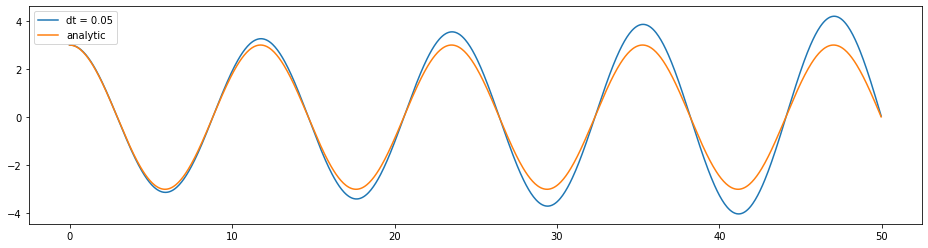

In [33]:
# Define the system.
k = 2.0
m = 7.0

# Choose initial conditions.
x = 3.0
v = 0.0

# Define the simulation.
N = 1000
dt = 0.05

# Prepare lists to collect the simulation data.
xs = [x]
vs = [v]

for step in range(N-1):
    newx, newv = SHO_euler_step(x=xs[step], v=vs[step], k=k, m=m, dt=dt)
    xs.append(newx)
    vs.append(newv)

times = dt*np.arange(N)

# Compute analytic solution for comparison
phase_pts_analytic = SHO_analytic(phase_pt0=[x, v], k=k, m=m, ts=times)

# Plot
fig = plt.figure(figsize=(16, 4))             
plt.plot(times, xs, '-', label='dt = {}'.format(dt))
plt.plot(times, phase_pts_analytic[:, 0], '-', label='analytic')
plt.legend()

# Not bad - it gets the basic idea.

What happens when you integrate for 10 times as many steps?

TRY: Show algebraically what is going on to the amplitude.

Maybe we need to "crank" up the resolution and use a smaller dt.

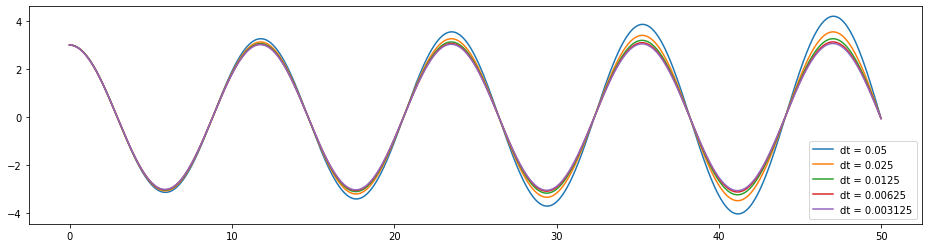

In [4]:
# Experiment with different values for dt.

# Choose initial conditions
x = 3.0
v = 0.0
k = 2.0
m = 7.0

fig = plt.figure(figsize=(16, 4))

T = 50
dt0 = 0.05

# Simulate and plot for several values of dt.
for dt in dt0 * 0.5**np.arange(0, 5): # Check your understanding of this line.

    N = int(T/dt)

    xs = [x]
    vs = [v]

    for step in range(N-1):
        newx, newv = SHO_euler_step(x=xs[step], v=vs[step], k=k, m=m, dt=dt)
        xs.append(newx)
        vs.append(newv)

    times = dt*np.arange(N)
    plt.plot(times, xs, '-', label='dt = {}'.format(dt))

plt.legend()

# Good enough?

The smallest value for dt looks pretty good.
But what if we want to model an oscillator that is running for $10^3$ periods?

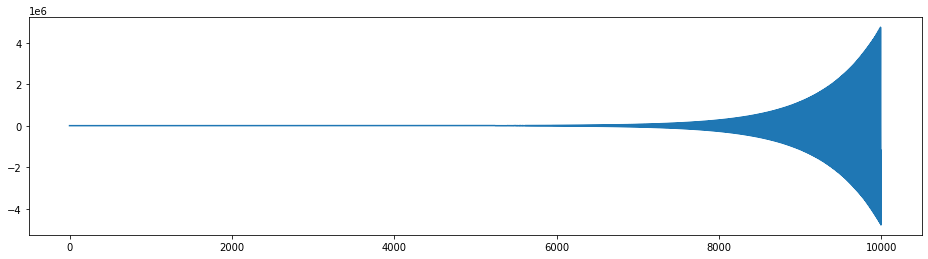

In [5]:
# Simulate 1000 periods.
N = 10**6 # YOUFILLIN
dt = 0.01

# Choose initial conditions
x = 3.0
v = 0.0
k = 2.0
m = 7.0

fig = plt.figure(figsize=(16, 4))

xs = [x]
vs = [v]

for step in range(N-1):
    newx, newv = SHO_euler_step(x=xs[step], v=vs[step], k=k, m=m, dt=dt)
    xs.append(newx)
    vs.append(newv)

times = dt*np.arange(N)
plt.plot(times, xs, '-', label='dt = {}'.format(dt))

In [6]:
def SHO_energy(x, v, k, m):
    """
    Total energy of simple harmonic oscillator.
    E = KE + PE = \frac{1}{2} m v^2 + \frac{1}{2} k x^2
    """
    return 0.5 * m * v**2 + 0.5 * k * x**2

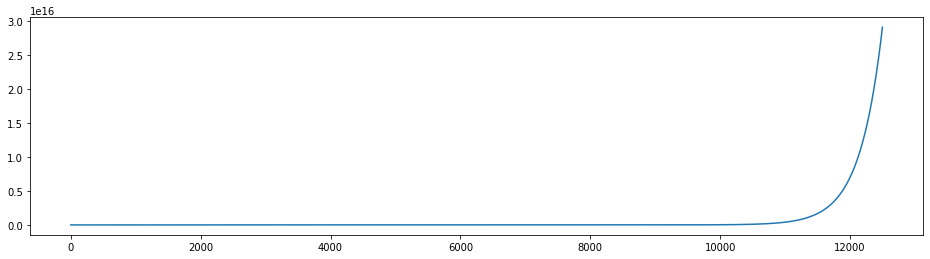

In [7]:
# Look at the evolution of energy.

N = 5000 * 250
dt = 0.01

# Choose initial conditions
x = 3.0
v = 0.0
k = 2.0
m = 7.0

fig = plt.figure(figsize=(16, 4))

xs = [x]
vs = [v]

for step in range(N-1):
    newx, newv = SHO_euler_step(x=xs[step], v=vs[step], k=k, m=m, dt=dt)
    xs.append(newx)
    vs.append(newv)

times = dt*np.arange(N)

# Different ways to compute the energies.
# Compute energies using a list.
energies = []
for ind in range(N):
    energies.append(SHO_energy(xs[ind], vs[ind], k, m))

# Compute energies using a list comprehension instead.
# energies = [SHO_energy(xs[ind], vs[ind], k, m) for ind in range(N)]

# If we convert the input lists to arrays, we can compute in a more "natural" way.
# Look at the SHO_energy function - the operations here all work "correctly" on numpy arrays too.
# TRY: Can you come up with an energy function that will *not correctly generalize to arrays?
# xs = np.array(xs)
# vs = np.array(vs)
# energies = SHO_energy(xs, vs, k, m)

plt.plot(times, energies, '-', label='dt = {}'.format(dt))

In [8]:
# What happens when we make a small change in the integration step?
# What is the change?
# What is it's local effect?
# What is the broader impact?

def SHO_euler_step2(x, v, k, m, dt):
    x += v * dt
    net_force = -k * x
    a = net_force / m
    v += a * dt
    return x, v

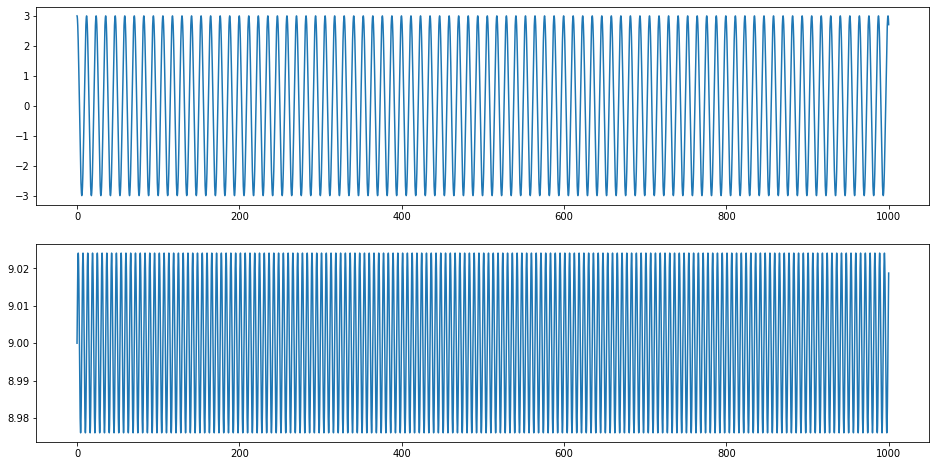

In [9]:
# Look at stability of this slightly different integration.

N = 5000*20
dt = 0.01

# Choose initial conditions
x = 3.0
v = 0.0
k = 2.0
m = 7.0

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

xs = [x]
vs = [v]

for step in range(N-1):
    newx, newv = SHO_euler_step2(x=xs[step], v=vs[step], k=k, m=m, dt=dt)
    xs.append(newx)
    vs.append(newv)

times = dt*np.arange(N)

ax[0].plot(times, xs, '-', label='dt = {}'.format(dt))

xs = np.array(xs)
vs = np.array(vs)
energies = SHO_energy(xs, vs, k, m)

ax[1].plot(times, energies, '-', label='dt = {}'.format(dt))

In [10]:
# TODO : Figure out "list reference issue".
# What is the cleanest way to handle this?

# Let's package things up a little more neatly.

import copy

def SHO_accel(x, k, m):
    return -k * x / m

def euler_step(phase_pt, accel_func, dt):
#    x, v = phase_pt[:]
#    phase_pt = copy.copy(phase_pt)
    a = accel_func(phase_pt)
    
    x = phase_pt[0] + phase_pt[1] * dt
    v = phase_pt[1] + a * dt
    return [x, v]

#     a = accel_func(phase_pt)
#     phase_pt[0] += phase_pt[1] * dt
#     phase_pt[1] += a * dt
#     return phase_pt

def euler_step2(phase_pt, accel_func, dt):
#     x, v = phase_pt[:]
#    phase_pt = copy.copy(phase_pt)
    x = phase_pt[0] + phase_pt[1] * dt
    a = accel_func([x, phase_pt[1]])
    v = phase_pt[1] + a * dt
    return [x, v]

#     phase_pt[0] += phase_pt[1] * dt
#     a = accel_func(phase_pt)
#     phase_pt[1] += a * dt
#     return phase_pt

def integrate(phase_pt0, accel_func, step_func, t0, T, N):
    
    dt = (T - t0)/N
    
    phase_pts = [phase_pt0]

    for step in range(N-1):
        phase_pt = step_func(phase_pt=phase_pts[step], accel_func=accel_func, dt=dt)
        phase_pts.append(phase_pt)

    times = dt*np.arange(N)

    return np.array(phase_pts), times

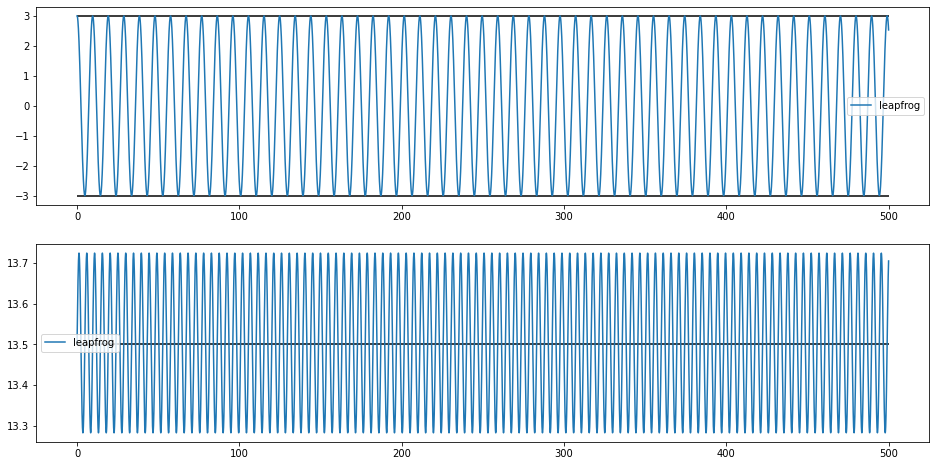

In [21]:
k = 3.0
m = 7.0

phase_pt0 = [3.0, 0.0]
t0 = 0
T = 500

N = 10000

accel_func = lambda phase_pt: SHO_accel(x=phase_pt[0], k=k, m=m)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Euler forward
# phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step, t0=t0, T=T, N=N)
# ax[0].plot(times, phase_pts[:, 0], '-', label='euler forward')
# ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='euler forward')

# Leapfrog(ish)
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step2, t0=t0, T=T, N=N)
ax[0].plot(times, phase_pts[:, 0], '-', label='leapfrog')
ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='leapfrog')

ax[0].hlines(phase_pt0[0], 0, T)
ax[0].hlines(-phase_pt0[0], 0, T)
ax[1].hlines(SHO_energy(phase_pt0[0], phase_pt0[1], k, m), 0, T)

ax[0].legend()
ax[1].legend()

In [12]:
# ASIDE: A python puzzle

LOLs = [[2,3]]
print(id(LOLs[0]))
listA = LOLs[0]
print(id(listA))
listA[0] += 1
print(id(listA))
LOLs.append(listA)
print(LOLs)

4728889608
4728889608
4728889608
[[3, 3], [3, 3]]


In [22]:
# The verlet integrator has the power of the leapfrog and also yields synchronous phase points.
# TODO : update this dependent on how we resolve the euler step reference issue.

def velocity_verlet_step(phase_pt, accel_func, dt):
    x, v = phase_pt
    a = accel_func(phase_pt)
    vhalf = v + 0.5 * a * dt
    x1 = x + vhalf * dt
    a = accel_func([x1, v])
    v1 = vhalf + 0.5 * a * dt

    return [x1, v1]

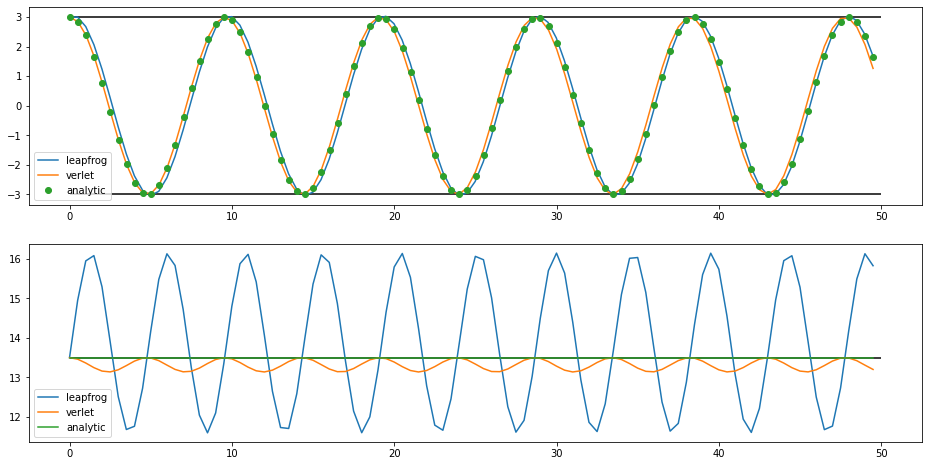

In [44]:
k = 3.0
m = 7.0

phase_pt0 = [3.0, 0.0]
t0 = 0
T = 50

N = 10**2

accel_func = lambda phase_pt: SHO_accel(x=phase_pt[0], k=k, m=m)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# # Euler forward
# phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step, t0=t0, T=T, N=N)
# ax[0].plot(times, phase_pts[:, 0], '-', label='euler forward')
# ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='euler forward')

# Leapfrog(ish)
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step2, t0=t0, T=T, N=N)
ax[0].plot(times-dt/2, phase_pts[:, 0], '-', label='leapfrog')
ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='leapfrog')

# Velocity verlet
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=velocity_verlet_step, t0=t0, T=T, N=N)
ax[0].plot(times, phase_pts[:, 0], '-', label='verlet')
ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='verlet')

# Analytic
phase_pts_analytic = SHO_analytic(phase_pt0=[x, v], k=k, m=m, ts=times)
ax[0].plot(times, phase_pts_analytic[:, 0], 'o', label='analytic')
ax[1].plot(times, SHO_energy(phase_pts_analytic[:, 0], phase_pts_analytic[:, 1], k=k, m=m), '-', label='analytic')

ax[0].hlines(phase_pt0[0], 0, T)
ax[0].hlines(-phase_pt0[0], 0, T)
ax[1].hlines(SHO_energy(phase_pt0[0], phase_pt0[1], k, m), 0, T)

ax[0].legend()
ax[1].legend()

In [ ]:
# Accuracy improves with decreasing dt - not surprising.
# TRY: can you imagine some kind of simulation where the accuracy became *worse* as dt became very, very small?

In [57]:
# Damped Harmonic Oscillator
def DHO_accel(x, v, k, m, b):
    return (-k * x - b * v) / m

# Analytic solutions of limiting behavior
def DHO_analytic_no_mass(phase_pt0, k, b, ts):
    """
    f = m a
    -kx - bv = 0 a
    x(t) = A \exp(-(k/b) t)
    v(t) = -A (k/b) \exp(-(k/b) t)
    
    x0 = x(0) = A
    v0 = v(0) = -A (k/b)
    """
    A = phase_pt0[0]
    
    xs = A * np.exp(-(k/b) * ts)
    vs = -A * (k/b) * np.exp(-(k/b) * ts)
    
    return np.column_stack([xs, vs])

def DHO_analytic(phase_pt0, k, m, b, ts):
    # TRY: Implement this analytic solution and compare with the numerical results.
    return

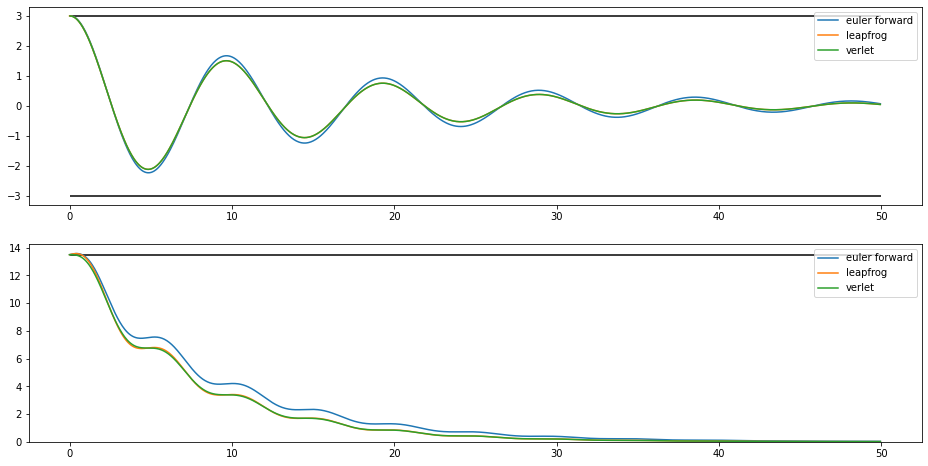

In [74]:
k = 3.0
m = 7.0
b = 1.0

phase_pt0 = [3.0, 0.0]
t0 = 0
T = 50

N = 10**3

accel_func = lambda phase_pt: DHO_accel(x=phase_pt[0], v = phase_pt[1], k=k, m=m, b=b)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Euler forward
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step, t0=t0, T=T, N=N)
ax[0].plot(times, phase_pts[:, 0], '-', label='euler forward')
ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='euler forward')

# Leapfrog(ish)
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step2, t0=t0, T=T, N=N)
ax[0].plot(times-dt/2, phase_pts[:, 0], '-', label='leapfrog')
ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='leapfrog')

# Velocity verlet
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=velocity_verlet_step, t0=t0, T=T, N=N)
ax[0].plot(times, phase_pts[:, 0], '-', label='verlet')
ax[1].plot(times, SHO_energy(phase_pts[:, 0], phase_pts[:, 1], k, m), label='verlet')

# # TRY: Use this analytic solution to check the limit where mass approaches zero.
# # Analytic
# phase_pts_analytic = DHO_analytic_no_mass(phase_pt0=[x, v], k=k, b=b, ts=times)
# ax[0].plot(times, phase_pts_analytic[:, 0], 'o', label='analytic')
# ax[1].plot(times, SHO_energy(phase_pts_analytic[:, 0], phase_pts_analytic[:, 1], k=k, m=m), '-', label='analytic')

ax[0].hlines(phase_pt0[0], 0, T)
ax[0].hlines(-phase_pt0[0], 0, T)
ax[1].hlines(SHO_energy(phase_pt0[0], phase_pt0[1], k, m), 0, T)

ax[1].set_ylim(bottom=0)
ax[0].legend()
ax[1].legend()

In [75]:
# Are the energies all monotonic?

In [80]:
# Anharmonic Oscillator
def AHO_accel(x, v, k, m, a):
    return (-k * x - a * x**3) / m

def AHO_energy(x, v, k, m, a):
    # TRY: Implement this energy function.
    
    return 0.5 * m * v**2 + 0.5 * k * x**2 + 0.25 * a * x**4

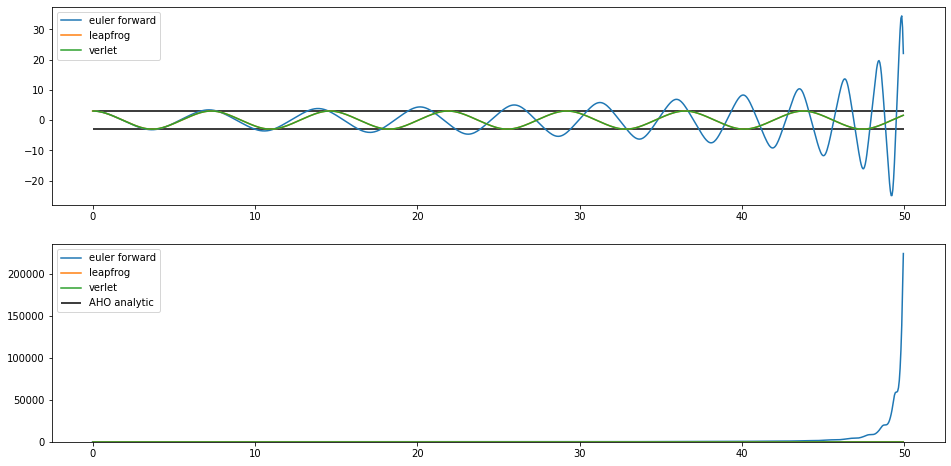

In [98]:
# Explore a little - notice how the euler integration easily yields an overflow error.
k = 3.0
m = 7.0
a = 0.33

phase_pt0 = [3.0, 0.0]
t0 = 0
T = 50

N = 10**3

accel_func = lambda phase_pt: AHO_accel(x=phase_pt[0], v = phase_pt[1], k=k, m=m, a=a)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Euler forward
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step, t0=t0, T=T, N=N)
ax[0].plot(times, phase_pts[:, 0], '-', label='euler forward')
ax[1].plot(times, AHO_energy(phase_pts[:, 0], phase_pts[:, 1], k=k, m=m, a=a), label='euler forward')

# Leapfrog(ish)
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step2, t0=t0, T=T, N=N)
ax[0].plot(times-dt/2, phase_pts[:, 0], '-', label='leapfrog')
ax[1].plot(times, AHO_energy(phase_pts[:, 0], phase_pts[:, 1], k=k, m=m, a=a), label='leapfrog')

# Velocity verlet
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=velocity_verlet_step, t0=t0, T=T, N=N)
ax[0].plot(times, phase_pts[:, 0], '-', label='verlet')
ax[1].plot(times, AHO_energy(phase_pts[:, 0], phase_pts[:, 1], k=k, m=m, a=a), label='verlet')

ax[0].hlines(phase_pt0[0], 0, T)
ax[0].hlines(-phase_pt0[0], 0, T)
ax[1].hlines(AHO_energy(phase_pt0[0], phase_pt0[1], k, m, a), 0, T, label='AHO analytic')

ax[1].set_ylim(bottom=0)
ax[0].legend()
ax[1].legend()

# Kepler problem for one planet around stationary Sun.

In [101]:
M = 1.989 * 10**30 # mass of Sun [kg]
G = 6.673*10**-11 # Newton's gravitational constant [N m2 kg-2]

def kepler_accel(x, y, G, M):
    rad = (x**2 + y**2)**0.5
    a = G * M / rad**2
    ax = - a * x / rad
    ay = - a * y / rad
    return [ax, ay]

In [104]:
def euler_step(phase_pt, accel_func, dt):
#    x, v = phase_pt[:]
#    phase_pt = copy.copy(phase_pt)
    a = accel_func(phase_pt)
    
    x = phase_pt[0] + phase_pt[2] * dt
    y = phase_pt[1] + phase_pt[3] * dt
    vx = phase_pt[2] + a[0] * dt
    vy = phase_pt[3] + a[1] * dt

    return [x, y, vx, vy]

#     a = accel_func(phase_pt)
#     phase_pt[0] += phase_pt[1] * dt
#     phase_pt[1] += a * dt
#     return phase_pt

def euler_step2(phase_pt, accel_func, dt):
#     x, v = phase_pt[:]
#    phase_pt = copy.copy(phase_pt)
    x = phase_pt[0] + phase_pt[1] * dt
    a = accel_func([x, phase_pt[1]])
    v = phase_pt[1] + a * dt
    return [x, v]

#     phase_pt[0] += phase_pt[1] * dt
#     a = accel_func(phase_pt)
#     phase_pt[1] += a * dt
#     return phase_pt

def velocity_verlet_step(phase_pt, accel_func, dt):
    x, v = phase_pt
    a = accel_func(phase_pt)
    vhalf = v + 0.5 * a * dt
    x1 = x + vhalf * dt
    a = accel_func([x1, v])
    v1 = vhalf + 0.5 * a * dt

    return [x1, v1]

def integrate(phase_pt0, accel_func, step_func, t0, T, N):
    
    dt = (T - t0)/N
    
    phase_pts = [phase_pt0]

    for step in range(N-1):
        phase_pt = step_func(phase_pt=phase_pts[step], accel_func=accel_func, dt=dt)
        phase_pts.append(phase_pt)

    times = dt*np.arange(N)

    return np.array(phase_pts), times

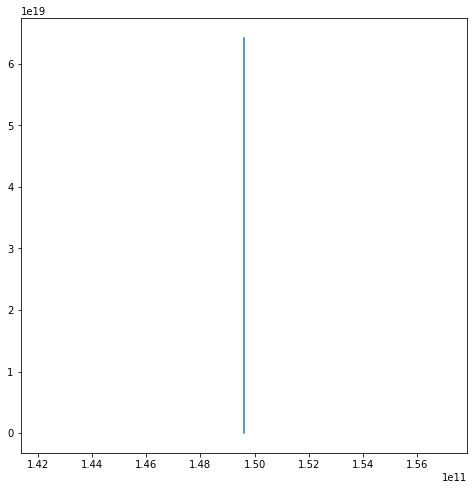

In [109]:
# Get something simple working
m = 5.972 * 10**24 # mass of Earth [kg]
orbital_rad = 149.6 * 10**9 # orbital radius of Earth [m]
orbital_speed = 107226000 * 60 #(approx) orbital speed of Earth around sun [m/s]

phase_pt0 = [orbital_rad, 0, 0, orbital_speed]
t0 = 0
T = 10**10

N = 10**3

accel_func = lambda phase_pt: kepler_accel(x=phase_pt[0], y = phase_pt[1], G=G, M=G)

fig = plt.figure(figsize=(8, 8))

# Euler forward
phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step, t0=t0, T=T, N=N)
plt.plot(phase_pts[:, 0], phase_pts[:, 1], '-', label='euler forward')

# ax[0].plot(times, phase_pts[:, 0], '-', label='euler forward')
#ax[1].plot(times, AHO_energy(phase_pts[:, 0], phase_pts[:, 1], k=k, m=m, a=a), label='euler forward')

# # Leapfrog(ish)
# phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=euler_step2, t0=t0, T=T, N=N)
# ax[0].plot(times-dt/2, phase_pts[:, 0], '-', label='leapfrog')
# ax[1].plot(times, AHO_energy(phase_pts[:, 0], phase_pts[:, 1], k=k, m=m, a=a), label='leapfrog')

# # Velocity verlet
# phase_pts, times = integrate(phase_pt0=phase_pt0, accel_func=accel_func, step_func=velocity_verlet_step, t0=t0, T=T, N=N)
# ax[0].plot(times, phase_pts[:, 0], '-', label='verlet')
# ax[1].plot(times, AHO_energy(phase_pts[:, 0], phase_pts[:, 1], k=k, m=m, a=a), label='verlet')

# ax[0].hlines(phase_pt0[0], 0, T)
# ax[0].hlines(-phase_pt0[0], 0, T)
# ax[1].hlines(AHO_energy(phase_pt0[0], phase_pt0[1], k, m, a), 0, T, label='AHO analytic')

# ax[1].set_ylim(bottom=0)
# ax[0].legend()
# ax[1].legend()